In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import os

# 表达矩阵与 metadata 配对列表
dataset_names = [
    "E-MTAB-316",
    "GSE5900",
    "GSE6477",
    "GSE13591"
]

# 合并所有表达数据
merged_expr = []
merged_meta = []

for name in dataset_names:
    expr = pd.read_csv(f"train/{name}.csv")
    meta = pd.read_csv(f"metadata/{name}_metadata.csv")[["SampleID", "label"]]
    merged = expr.merge(meta, on="SampleID", how="left")
    merged_expr.append(merged)

# 合并所有数据集
df = pd.concat(merged_expr, ignore_index=True)
df = df.dropna(subset=["label"])
df["Group"] = df["label"].astype(int)

# 设置数据
y = df["Group"].values
gene_cols = df.drop(columns=["SampleID", "Dataset", "Group", "label"]).columns
X = df[gene_cols]

# 执行逐基因 Logistic 回归
results = []
for gene in gene_cols:
    x = X[[gene]].values
    y_unique = np.unique(y)
    if len(y_unique) < 2:
        continue
    try:
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        model.fit(x, y)
        beta = model.coef_[0][0]
        pred = model.predict_proba(x)[:, 1]
        var = np.var(x[:, 0])
        eps = 1e-9
        se = np.sqrt(np.sum(pred * (1 - pred)) / (x.shape[0] * var + eps))
        z = beta / (se + eps)
        p = 2 * (1 - norm.cdf(abs(z)))
        results.append((gene, beta, p))
    except:
        continue

# 构建结果表
res_df = pd.DataFrame(results, columns=["Gene", "Beta", "P"])
res_df["FDR"] = multipletests(res_df["P"], method="fdr_bh")[1]
res_df["Significant"] = res_df["FDR"] < 0.05

# 输出结果
res_df.to_csv("train/combined_logit_results.csv", index=False)
print(f"✅ 合并分析完成，结果保存为 train/combined_logit_results.csv（共 {len(res_df)} 个基因）")

✅ 合并分析完成，结果保存为 train/combined_logit_results.csv（共 12920 个基因）


✅ AUC 计算完成，结果保存为 train/combined_auc_scores.csv


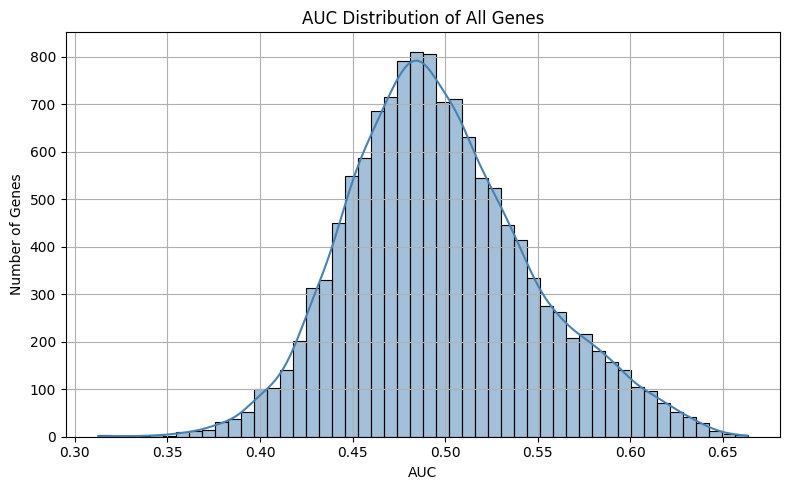

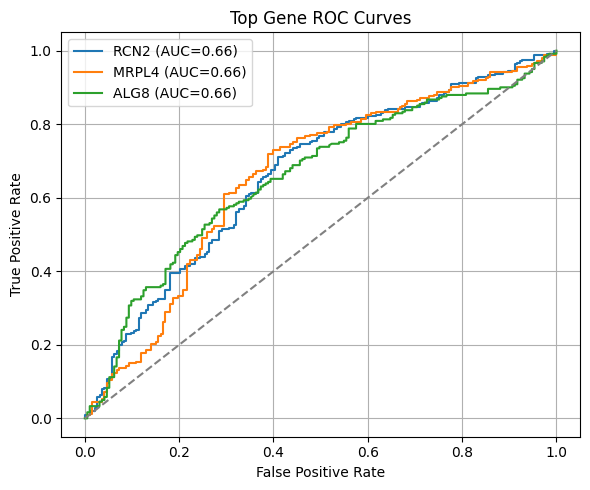

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 读取表达和元数据
dataset_names = ["E-MTAB-316", "GSE5900", "GSE6477", "GSE13591"]

merged_expr = []
for name in dataset_names:
    expr = pd.read_csv(f"train/{name}.csv")
    meta = pd.read_csv(f"metadata/{name}_metadata.csv")[["SampleID", "label"]]
    merged = expr.merge(meta, on="SampleID", how="left")
    merged_expr.append(merged)

# 合并并处理数据
df = pd.concat(merged_expr, ignore_index=True)
df = df.dropna(subset=["label"])
df["Group"] = df["label"].astype(int)

# 设置变量
y = df["Group"].values
gene_cols = df.drop(columns=["SampleID", "Dataset", "Group", "label"]).columns
X = df[gene_cols]

# 计算每个基因的 AUC
auc_results = []
for gene in gene_cols:
    try:
        x = X[gene].values.reshape(-1, 1)
        if len(np.unique(x)) <= 1:
            continue
        auc = roc_auc_score(y, x)
        auc_results.append((gene, auc))
    except:
        continue

# 转为 DataFrame
auc_df = pd.DataFrame(auc_results, columns=["Gene", "AUC"]).sort_values(by="AUC", ascending=False)

# 保存 AUC 结果
auc_df.to_csv("train/combined_auc_scores.csv", index=False)
print("✅ AUC 计算完成，结果保存为 train/combined_auc_scores.csv")

# 绘制 AUC 分布图
plt.figure(figsize=(8, 5))
sns.histplot(auc_df["AUC"], bins=50, kde=True, color='steelblue')
plt.title("AUC Distribution of All Genes")
plt.xlabel("AUC")
plt.ylabel("Number of Genes")
plt.grid(True)
plt.tight_layout()
plt.savefig("train/combined_auc_distribution.png", dpi=300)
plt.show()

# 可选：展示前 3 个基因的 ROC 曲线
top_genes = auc_df.head(3)["Gene"]
plt.figure(figsize=(6, 5))
for gene in top_genes:
    x = X[gene].values.reshape(-1, 1)
    fpr, tpr, _ = roc_curve(y, x)
    plt.plot(fpr, tpr, label=f"{gene} (AUC={roc_auc_score(y, x):.2f})")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("Top Gene ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train/top_genes_roc_curves.png", dpi=300)
plt.show()

✅ 逻辑回归AUC计算完成，结果保存为 logistic_regression_auc_scores.csv


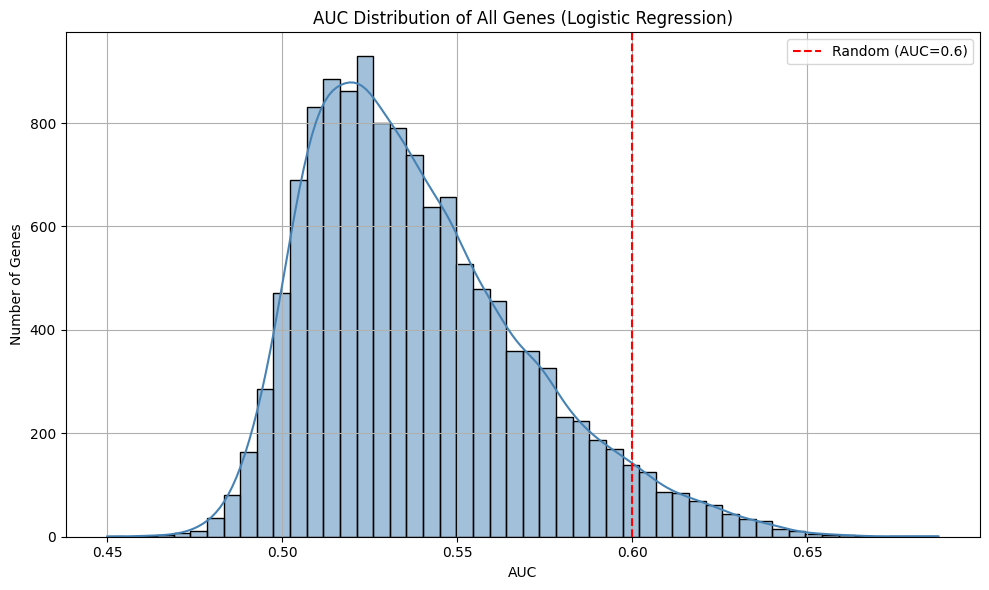

In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# 忽略警告
warnings.filterwarnings('ignore')

# 读取表达和元数据
dataset_names = ["E-MTAB-316", "GSE5900", "GSE6477", "GSE13591"]

merged_expr = []
for name in dataset_names:
    expr = pd.read_csv(f"../train/{name}.csv")
    meta = pd.read_csv(f"../metadata/{name}_metadata.csv")[["SampleID", "label"]]
    merged = expr.merge(meta, on="SampleID", how="left")
    merged["Dataset"] = name  # 添加数据集标识
    merged_expr.append(merged)

# 合并并处理数据
df = pd.concat(merged_expr, ignore_index=True)
df = df.dropna(subset=["label"])
df["Group"] = df["label"].astype(int)

# 设置变量
y = df["Group"].values
gene_cols = df.drop(columns=["SampleID", "Dataset", "Group", "label"]).columns
X = df[gene_cols]

# 标准化数据 - 逻辑回归需要
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=gene_cols)

# 计算每个基因的 AUC（使用逻辑回归）
auc_results = []
coef_results = []

for gene in gene_cols:
    try:
        # 获取单个基因的表达值
        x = X_scaled[gene].values.reshape(-1, 1)
        
        # 跳过方差过小的基因
        if len(np.unique(x)) <= 1 or np.std(x) < 1e-5:
            continue
            
        # 训练逻辑回归模型
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        model.fit(x, y)
        
        # 预测概率
        y_pred_proba = model.predict_proba(x)[:, 1]
        
        # 计算AUC
        auc = roc_auc_score(y, y_pred_proba)
        
        # 保存结果
        auc_results.append((gene, auc, model.coef_[0][0], model.intercept_[0]))
    except Exception as e:
        print(f"处理基因 {gene} 时出错: {str(e)}")
        continue

# 转为 DataFrame
auc_df = pd.DataFrame(auc_results, columns=["Gene", "AUC", "Coefficient", "Intercept"])
auc_df = auc_df.sort_values(by="AUC", ascending=False)

# 保存 AUC 结果
auc_df.to_csv("logistic_regression_auc_scores.csv", index=False)
print("✅ 逻辑回归AUC计算完成，结果保存为 logistic_regression_auc_scores.csv")

# 绘制 AUC 分布图
plt.figure(figsize=(10, 6))
sns.histplot(auc_df["AUC"], bins=50, kde=True, color='steelblue')
plt.axvline(0.6, color='red', linestyle='--', label='Random (AUC=0.6)')
plt.title("AUC Distribution of All Genes (Logistic Regression)")
plt.xlabel("AUC")
plt.ylabel("Number of Genes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("logistic_auc_distribution.png", dpi=300)
plt.show()


✅ 逻辑回归分析完成，结果保存为 train/logistic_regression_results_with_fdr.csv
在 12920 个测试基因中，0 个基因在 FDR < 0.05 水平下显著


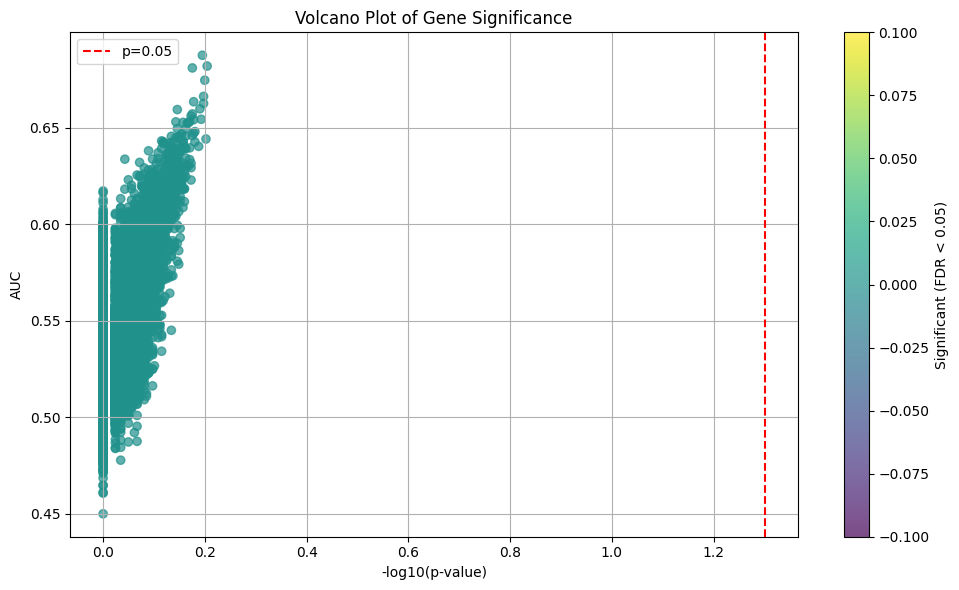

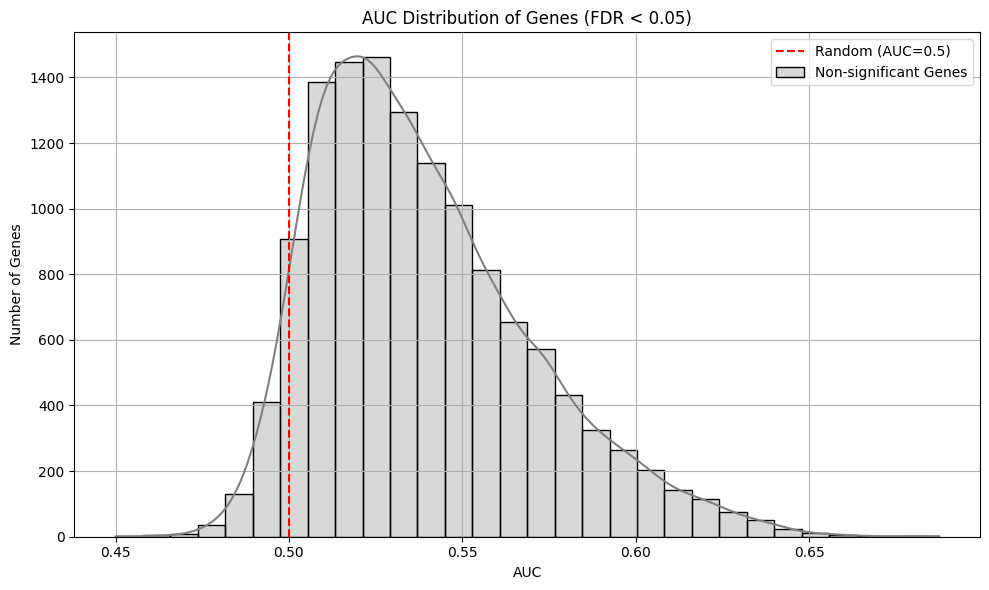

NameError: name 'significant_genes' is not defined

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy import stats
from statsmodels.stats.multitest import multipletests

# 忽略警告
warnings.filterwarnings('ignore')

# 读取表达和元数据
dataset_names = ["E-MTAB-316", "GSE5900", "GSE6477", "GSE13591"]

merged_expr = []
for name in dataset_names:
    expr = pd.read_csv(f"../train/{name}.csv")
    meta = pd.read_csv(f"../metadata/{name}_metadata.csv")[["SampleID", "label"]]
    merged = expr.merge(meta, on="SampleID", how="left")
    merged["Dataset"] = name  # 添加数据集标识
    merged_expr.append(merged)

# 合并并处理数据
df = pd.concat(merged_expr, ignore_index=True)
df = df.dropna(subset=["label"])
df["Group"] = df["label"].astype(int)

# 设置变量
y = df["Group"].values
gene_cols = df.drop(columns=["SampleID", "Dataset", "Group", "label"]).columns
X = df[gene_cols]

# 标准化数据 - 逻辑回归需要
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=gene_cols)

# 计算每个基因的 AUC 和 p 值（使用逻辑回归）
auc_results = []
coef_results = []
p_values = []
genes_tested = []

for gene in gene_cols:
    try:
        # 获取单个基因的表达值
        x = X_scaled[gene].values.reshape(-1, 1)
        
        # 跳过方差过小的基因
        if len(np.unique(x)) <= 1 or np.std(x) < 1e-5:
            continue
            
        # 训练逻辑回归模型
        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        model.fit(x, y)
        
        # 预测概率
        y_pred_proba = model.predict_proba(x)[:, 1]
        
        # 计算AUC
        auc = roc_auc_score(y, y_pred_proba)
        
        # 计算 p 值 - 使用似然比检验
        # 零模型（只有截距）
        null_model = LogisticRegression(penalty=None, solver='lbfgs', fit_intercept=True, 
                                       intercept_scaling=10000, max_iter=1000)
        null_model.fit(np.zeros_like(x), y)
        
        # 计算似然比统计量
        llf_full = model.score(x, y)  # 完整模型的对数似然
        llf_null = null_model.score(np.zeros_like(x), y)  # 零模型的对数似然
        
        # 似然比统计量
        lr_stat = 2 * (llf_full - llf_null)
        
        # 计算 p 值（自由度为1的卡方分布）
        p_value = stats.chi2.sf(lr_stat, df=1)
        
        # 保存结果
        auc_results.append(auc)
        coef_results.append(model.coef_[0][0])
        p_values.append(p_value)
        genes_tested.append(gene)
        
    except Exception as e:
        print(f"处理基因 {gene} 时出错: {str(e)}")
        continue

# 创建结果DataFrame
results_df = pd.DataFrame({
    "Gene": genes_tested,
    "AUC": auc_results,
    "Coefficient": coef_results,
    "P_value": p_values
})

# 添加 FDR 校正 (Benjamini-Hochberg 方法)
reject, pvals_corrected, _, _ = multipletests(
    results_df["P_value"], 
    alpha=0.05, 
    method='fdr_bh'
)

results_df["FDR"] = pvals_corrected
results_df["Significant"] = reject

# 按 AUC 排序
results_df = results_df.sort_values(by="AUC", ascending=False)

# 保存结果
#results_df.to_csv("train/logistic_regression_results_with_fdr.csv", index=False)
print("✅ 逻辑回归分析完成，结果保存为 train/logistic_regression_results_with_fdr.csv")

# 结果报告
n_significant = results_df["Significant"].sum()
print(f"在 {len(results_df)} 个测试基因中，{n_significant} 个基因在 FDR < 0.05 水平下显著")

# 绘制 FDR 校正结果
plt.figure(figsize=(10, 6))

# 绘制原始 p 值和校正后 FDR
plt.scatter(-np.log10(results_df["P_value"]), results_df["AUC"], 
            c=results_df["Significant"], cmap="viridis", alpha=0.7)
plt.axvline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.xlabel("-log10(p-value)")
plt.ylabel("AUC")
plt.title("Volcano Plot of Gene Significance")
plt.colorbar(label="Significant (FDR < 0.05)")
plt.grid(True)
plt.legend()
plt.tight_layout()
#plt.savefig("train/volcano_plot.png", dpi=300)
plt.show()

# 绘制显著基因的 AUC 分布
plt.figure(figsize=(10, 6))
sns.histplot(results_df[results_df["Significant"]]["AUC"], bins=30, kde=True, 
             color='green', label="Significant Genes")
sns.histplot(results_df[~results_df["Significant"]]["AUC"], bins=30, kde=True, 
             color='gray', alpha=0.3, label="Non-significant Genes")
plt.axvline(0.5, color='red', linestyle='--', label='Random (AUC=0.5)')
plt.title("AUC Distribution of Genes (FDR < 0.05)")
plt.xlabel("AUC")
plt.ylabel("Number of Genes")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("train/significant_genes_auc_distribution.png", dpi=300)
plt.show()

# 保存显著基因列表
#significant_genes = results_df[results_df["Significant"]].sort_values(by="AUC", ascending=False)
#significant_genes.to_csv("train/significant_genes.csv", index=False)
print(f"✅ 保存了 {len(significant_genes)} 个显著基因到 train/significant_genes.csv")

# 输出前10个显著基因
print("\nTop 10 significant genes:")
print(significant_genes[["Gene", "AUC", "FDR"]].head(10).to_string(index=False))

print("\n分析完成！所有结果已保存到 train/ 目录")

In [10]:
import pandas as pd

# 读取 combined_logit_results.csv 文件
df = pd.read_csv("combined_logit_results.csv")

# 定义多个 FDR 阈值
thresholds = [0.001, 0.01, 0.05, 0.1, 0.2]

# 统计每个阈值下的显著基因数
for thresh in thresholds:
    count = (df['FDR'] < thresh).sum()
    print(f"FDR < {thresh}: 显著基因数 = {count}")

FDR < 0.001: 显著基因数 = 0
FDR < 0.01: 显著基因数 = 0
FDR < 0.05: 显著基因数 = 0
FDR < 0.1: 显著基因数 = 0
FDR < 0.2: 显著基因数 = 0


In [11]:
import pandas as pd

# 读取你的 logistic 回归结果文件
df = pd.read_csv("logistic_regression_auc_scores.csv")

# 定义多个 AUC 阈值
thresholds = [0.5, 0.55, 0.58, 0.6, 0.65]

# 遍历并输出每个阈值下的基因数量
for thresh in thresholds:
    count = (df['AUC'] > thresh).sum()
    print(f"AUC > {thresh}: 基因数 = {count}")

AUC > 0.5: 基因数 = 12121
AUC > 0.55: 基因数 = 3993
AUC > 0.58: 基因数 = 1455
AUC > 0.6: 基因数 = 638
AUC > 0.65: 基因数 = 18


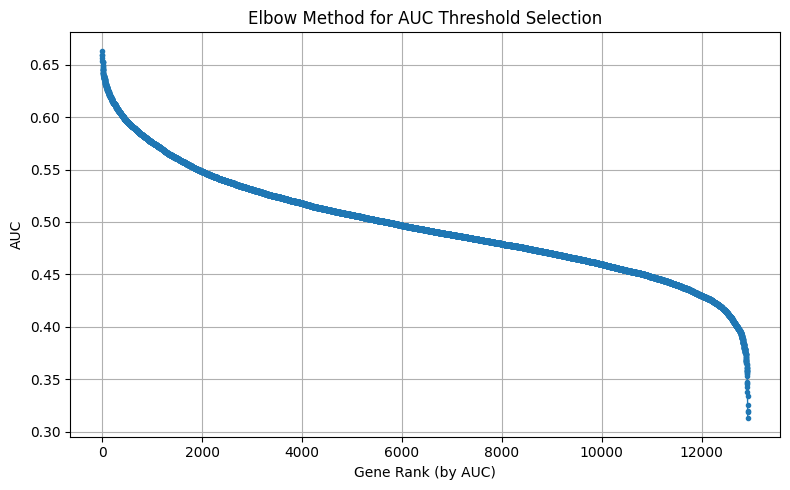

肘部位置 = 80, AUC 阈值 ≈ 0.6298


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
df = pd.read_csv("combined_auc_scores.csv")

# 对 AUC 值进行降序排序
sorted_auc = df['AUC'].sort_values(ascending=False).values

# 生成排名（从 1 开始）
ranks = np.arange(1, len(sorted_auc) + 1)

# 画图
plt.figure(figsize=(8, 5))
plt.plot(ranks, sorted_auc, marker='.', linewidth=1)
plt.xlabel('Gene Rank (by AUC)')
plt.ylabel('AUC')
plt.title('Elbow Method for AUC Threshold Selection')
plt.grid(True)
plt.tight_layout()
plt.show()

from kneed import KneeLocator

knee = KneeLocator(ranks, sorted_auc, curve='convex', direction='decreasing')
elbow_point = knee.knee
elbow_auc = sorted_auc[elbow_point - 1]

print(f"肘部位置 = {elbow_point}, AUC 阈值 ≈ {elbow_auc:.4f}")